In [1]:
import numpy as np
import MulensModel as mm
import matplotlib.pyplot as plt
import h5py
from tqdm.notebook import tqdm

In [2]:
with h5py.File(f'/work/hmzhao/irregular-lc/KMT-fixrho-0.h5', 'r') as opt:
    X = opt['X'][...]
    Y = opt['Y'][...]
X = X[:, :, :2]

In [3]:
def add_gap(X, n_chunks=25):
    gap_len = X.shape[1] // n_chunks
    gap_left = np.random.randint(0, X.shape[1]-gap_len, (len(X),))
    X_gap = np.zeros((X.shape[0], X.shape[1]-gap_len, X.shape[2]))
    for i in range(len(X)):
        left, gap, right = np.split(X[i], [gap_left[i], gap_left[i] + gap_len], axis=0)
        lc = np.vstack([left, right])
        X_gap[i] = lc
    return X_gap

def simulate_lc(t_0, t_E, u_0, rho, q, s, alpha, fs, relative_uncertainty=0, n_points=500, times=None,
                point_source=False, return_times=False):
    time_settings = {
            'type': 'random',
            'n_epochs': n_points,
            't_start': t_0-2*t_E,
            't_stop': t_0+2*t_E,
        }
    if times is None:
        raw = np.random.rand(time_settings['n_epochs'])
        dt = time_settings['t_stop'] - time_settings['t_start']
        times = time_settings['t_start'] + np.sort(raw) * dt
    if point_source:
        parameters = {
            't_0': t_0,
            't_E': t_E,
            'u_0': u_0,
            'q': q, 
            's': s, 
            'alpha': alpha,
        }
    else:
        parameters = {
            't_0': t_0,
            't_E': t_E,
            'u_0': u_0,
            'rho': rho, 
            'q': q, 
            's': s, 
            'alpha': alpha,
        }
    modelmm = mm.Model(parameters, coords=None)
    # times = modelmm.set_times(t_start=parameters['t_0']-2*parameters['t_E'], t_stop=parameters['t_0']+2*parameters['t_E'], n_epochs=n_points)
    if point_source:
        modelmm.set_magnification_methods([parameters['t_0']-2*parameters['t_E'], 'point_source', parameters['t_0']+2*parameters['t_E']])
    else:
        modelmm.set_magnification_methods([parameters['t_0']-2*parameters['t_E'], 'VBBL', parameters['t_0']+2*parameters['t_E']])
    magnification = modelmm.get_magnification(times)
    flux = 1000 * (magnification + (1-fs)/fs)
    flux *= 1 + relative_uncertainty * np.random.randn(len(flux))
    mag = (22 - 2.5 * np.log10(flux))
    lc = np.stack([times, mag], axis=-1)
    if return_times:
        return lc, times
    return lc

In [4]:
X = add_gap(X)

[0.00000000e+00 1.00000000e+00 1.48898486e-02 3.17315413e-03
 1.72476569e-01 7.47236727e-01 1.03581921e+02 8.42693693e-01]
15.980926467487762 1091.2970397138704


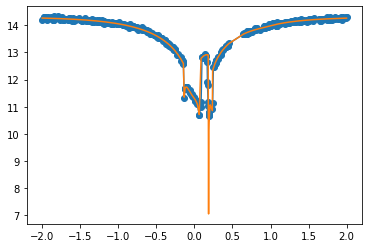

In [34]:
i = 8
relative_uncertainty = 0.03
params = Y[i].copy()
params[3] = 10.**np.random.uniform(-4, -2)
times = X[i, :, 0]
data = simulate_lc(*params, relative_uncertainty=relative_uncertainty, times=times)
lc = simulate_lc(*params, relative_uncertainty=0, times=times)
lc_ps = simulate_lc(*params, relative_uncertainty=0, point_source=True, times=times)
plt.scatter(times, data[:, 1])
plt.plot(times, lc[:, 1])
plt.plot(times, lc_ps[:, 1])
print(params)
chi2 = np.sum(((data[:, 1] - lc[:, 1]) / (2.5 * np.log(10) * relative_uncertainty))**2)
chi2_ps = np.sum(((data[:, 1] - lc_ps[:, 1]) / (2.5 * np.log(10) * relative_uncertainty))**2)
print(chi2, chi2_ps)

In [26]:
dchi2 = []
Y_rho = np.zeros_like(Y)
for i in tqdm(range(len(X)//100)):
    params = Y[i].copy()
    params[3] = 10.**np.random.uniform(-4, -2)
    times = X[i, :, 0]
    data = simulate_lc(*params, relative_uncertainty=relative_uncertainty, times=times)
    lc = simulate_lc(*params, relative_uncertainty=0, times=times)
    lc_ps = simulate_lc(*params, relative_uncertainty=0, point_source=True, times=times)
    chi2 = np.sum(((data[:, 1] - lc[:, 1]) / (2.5 * np.log(10) * relative_uncertainty))**2)
    chi2_ps = np.sum(((data[:, 1] - lc_ps[:, 1]) / (2.5 * np.log(10) * relative_uncertainty))**2)
    dchi2.append(chi2_ps - chi2)
    Y_rho[i] = params

  0%|          | 0/1000 [00:00<?, ?it/s]

(array([844.,  36.,  31.,  20.,  15.,  11.,  15.,   7.,   3.,   1.,   3.,
          9.,   0.,   0.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([-1.36331266e-01,  1.80079195e+01,  3.61521702e+01,  5.42964210e+01,
         7.24406717e+01,  9.05849225e+01,  1.08729173e+02,  1.26873424e+02,
         1.45017675e+02,  1.63161925e+02,  1.81306176e+02,  1.99450427e+02,
         2.17594678e+02,  2.35738928e+02,  2.53883179e+02,  2.72027430e+02,
         2.901

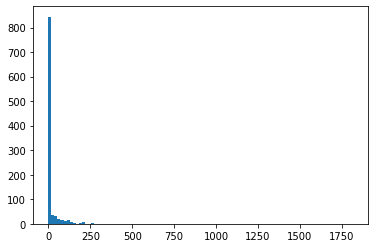

In [36]:
plt.hist(dchi2, bins=100)